## 패키지 가져오기

In [1]:
from pykrx import stock
from pykrx import bond
import pandas_datareader.data as web
import FinanceDataReader as fdr

from talib import RSI, BBANDS, MACD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from datetime import datetime
import time
from tqdm import tqdm

import multiprocessing as mp
from multiprocessing import Pool, Manager

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_cores = mp.cpu_count()
print(f"사용가능한 코어 수: {num_cores}")

사용가능한 코어 수: 8


In [3]:
# 2023년 3월 1일 기준 KOSPI와 KOSDAQ의 종목 수를 파악
start_date, end_date = "2015-02-11", "2023-03-01"
kospi_tickers = stock.get_market_ticker_list(end_date, market='KOSPI')
kosdaq_tickers = stock.get_market_ticker_list(end_date, market='KOSDAQ')
all_tickers = kospi_tickers + kosdaq_tickers

print("KOSPI 종목 수: ", len(kospi_tickers))
print("KOSDAQ 종목 수: ", len(kosdaq_tickers))
print("전체 종목 수: ", len(all_tickers))

KOSPI 종목 수:  943
KOSDAQ 종목 수:  1615
전체 종목 수:  2558


## 전략 수립 및 구현

최근 1,3,6개월의 수익률이 높은 주식을 매수하는 전략(Long Only)  
각 자산의 매수 및 매도 비중은 동일 가중 방식을 사용하여 결정. 리밸런싱 주기는 1개월로 설정.   
이 때, 수익률이 양수인 주식을 최대 50개까지 매수   
2015년 3월~2023년 2월에 KOSPI, KOSDAQ에 있는 모든 주식을 대상으로 전략을 실행.  

In [5]:
# 1개월을 기준으로 rebalancing을 실시
start_date, end_date = "2014-02-01", "2023-03-01"
all_dates = stock.get_market_ohlcv(start_date, end_date, "005930").index
all_dates = all_dates.to_frame('Dates').resample("M").first()['날짜'].tolist()
all_dates = [x.strftime("%Y-%m-%d") for x in all_dates]

In [6]:
# 쓰이는 모든 티커들을 모음
all_tickers = []
for date in tqdm(all_dates):
    kospi_tickers = stock.get_market_ticker_list(date, market='KOSPI')
    kosdaq_tickers = stock.get_market_ticker_list(date, market='KOSDAQ')
    all_tickers += kospi_tickers
    all_tickers += kosdaq_tickers
all_tickers = list(set(all_tickers))
print(f"해당 기간동안의 모든 ticker 개수는 {len(all_tickers)}")

100%|██████████| 109/109 [00:53<00:00,  2.03it/s]

해당 기간동안의 모든 ticker 개수는 2910


In [7]:
def return_price_df(tickers, start_date, end_date):
    df = pd.DataFrame()
    for ticker in tqdm(tickers):
        price_df = stock.get_market_ohlcv(start_date, end_date, ticker)['종가'].to_frame(ticker)
        df = pd.concat([df, price_df], axis=1)
    return df

price_df = return_price_df(all_tickers, start_date, end_date)
price_df.to_csv('momentum_price_df.csv')

100%|██████████| 2910/2910 [04:20<00:00, 11.16it/s]


In [8]:
price_df = pd.read_csv('momentum_price_df.csv', index_col=0)
price_df = price_df.fillna(0)
price_df.index = pd.to_datetime(price_df.index, format='%Y-%m-%d')
price_df.head()

,072130,057880,151860,002150,298040,039310,219420,352480,214450,044340,...,123840,004140,377480,260930,049720,055490,005870,001840,432320,391710
날짜,,,,,,,,,,,,,,,,,,,,,
2014-02-03,3750,1829,4845,5000,0.0,4730,0.0,0.0,0.0,12000,...,1558,2011,0.0,0.0,900,0.0,4290,4705,0.0,0.0
2014-02-04,3750,1815,4780,4950,0.0,4725,0.0,0.0,0.0,11950,...,1558,1948,0.0,0.0,879,0.0,4210,4344,0.0,0.0
2014-02-05,3760,1810,4745,4985,0.0,4610,0.0,0.0,0.0,11450,...,1563,1935,0.0,0.0,894,0.0,4245,4056,0.0,0.0
2014-02-06,3765,1782,4740,4985,0.0,4665,0.0,0.0,0.0,12300,...,1541,2024,0.0,0.0,890,0.0,4300,4376,0.0,0.0
2014-02-07,3830,1834,4705,4990,0.0,4570,0.0,0.0,0.0,12750,...,1532,2041,0.0,0.0,890,0.0,4300,4416,0.0,0.0


In [9]:
momentum_1 = price_df.resample("M").last().pct_change(1).replace(np.inf,0).fillna(0).iloc[1:, :]
momentum_3 = price_df.resample("M").last().pct_change(3).replace(np.inf, 0).fillna(0).iloc[3:, :]
momentum_6 = price_df.resample("M").last().pct_change(6).replace(np.inf, 0).fillna(0).iloc[6:, :]
momentum_9 = price_df.resample("M").last().pct_change(9).replace(np.inf, 0).fillna(0).iloc[9:, :]
momentum_12 = price_df.resample("M").last().pct_change(12).replace(np.inf, 0).fillna(0).iloc[12:, :]

In [10]:
def change_period(df):
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    df = df[df.index >= "2015-02-01"]
    return df
momentum_1 = change_period(momentum_1)
momentum_3 = change_period(momentum_3)
momentum_6 = change_period(momentum_6)
momentum_9 = change_period(momentum_9)
momentum_12 = change_period(momentum_12)
price_df = price_df[price_df.index >= "2015-03-01"]

In [11]:
def calculate_weights(momentum_df, long=50):
    long_signal = ((momentum_df
                  .where(momentum_df > 0)
                  .rank(axis=1, ascending=False) <= long)
                  .astype(int))
    def calculate_weights_from_signal(arr):
        signal = (arr == 1).astype(int)
        cnt = np.clip(np.sum(arr == 1), 0, long)
        if cnt > 0:
            signal = signal / cnt
        return signal
    long_signal = long_signal.apply(calculate_weights_from_signal, axis=1)
    return long_signal

In [12]:
momentum_1_weights = calculate_weights(momentum_1)
momentum_3_weights = calculate_weights(momentum_3)
momentum_6_weights = calculate_weights(momentum_6)
momentum_9_weights = calculate_weights(momentum_9)
momentum_12_weights = calculate_weights(momentum_12)

In [13]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.head()

,072130,057880,151860,002150,298040,039310,219420,352480,214450,044340,...,123840,004140,377480,260930,049720,055490,005870,001840,432320,391710
날짜,,,,,,,,,,,,,,,,,,,,,
2015-03-02,0.012090,-0.081330,0.046243,0.017986,0.0,0.008685,0.0,0.0,0.0,0.024590,...,0.015165,0.009254,0.0,0.0,0.102564,0.0,0.006590,-0.007453,0.0,0.0
2015-03-03,-0.020478,0.148107,-0.005525,0.016490,0.0,0.003690,0.0,0.0,0.0,-0.010667,...,-0.069420,0.011327,0.0,0.0,0.091234,0.0,-0.008183,0.016270,0.0,0.0
2015-03-04,0.034843,0.004365,-0.012963,0.005794,0.0,0.018382,0.0,0.0,0.0,0.032345,...,-0.003777,-0.009067,0.0,0.0,-0.104918,0.0,-0.003300,0.000000,0.0,0.0
2015-03-05,-0.018519,-0.087880,-0.009381,0.019585,0.0,0.000000,0.0,0.0,0.0,0.031332,...,-0.029384,0.000000,0.0,0.0,0.000000,0.0,-0.004967,-0.014778,0.0,0.0
2015-03-06,-0.056604,-0.100582,-0.015152,0.003390,0.0,-0.020457,0.0,0.0,0.0,0.070886,...,-0.007812,-0.022605,0.0,0.0,-0.047619,0.0,-0.026622,-0.003750,0.0,0.0


In [14]:
def change_weight_period(fwd_return, momentum_weights):
    temp_weights = fwd_return.copy()
    for i in range(len(momentum_weights.index)-1):
        day1 = momentum_weights.index[i]
        day2 = momentum_weights.index[i+1]
        temp = momentum_weights.iloc[i,:]
        temp_weights[(temp_weights.index >= day1) & (temp_weights.index < day2)] = temp
    return temp_weights

In [15]:
momentum_1_weights = change_weight_period(fwd_return, momentum_1_weights)
momentum_3_weights = change_weight_period(fwd_return, momentum_3_weights)
momentum_6_weights = change_weight_period(fwd_return, momentum_6_weights)
momentum_9_weights = change_weight_period(fwd_return, momentum_9_weights)
momentum_12_weights = change_weight_period(fwd_return, momentum_12_weights)

In [16]:
# 일별 수익률 계산
daily_return = pd.DataFrame()
daily_return['momentum_1'] = momentum_1_weights.mul(fwd_return).sum(axis=1)
daily_return['momentum_3'] = momentum_3_weights.mul(fwd_return).sum(axis=1)
daily_return['momentum_6'] = momentum_6_weights.mul(fwd_return).sum(axis=1)
daily_return['momentum_9'] = momentum_9_weights.mul(fwd_return).sum(axis=1)
daily_return['momentum_12'] = momentum_12_weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2015-03-01") & (daily_return.index < "2023-02-28")]
daily_return.head()

,momentum_1,momentum_3,momentum_6,momentum_9,momentum_12
날짜,,,,,
2015-03-02,0.002524,0.011857,0.006532,0.002504,0.003173
2015-03-03,0.021801,0.010181,0.010629,0.017581,0.016783
2015-03-04,-0.000879,0.006205,0.008759,0.005131,0.003289
2015-03-05,0.010656,0.003422,-0.016894,-0.003173,-0.002495
2015-03-06,-0.006688,-0.013753,-0.009860,-0.008380,-0.011037


In [17]:
cumulative_return = daily_return.copy()
for col in cumulative_return.columns:
    cumulative_return[col] = np.exp(np.log(daily_return[col]+1).cumsum())-1
cumulative_return

,momentum_1,momentum_3,momentum_6,momentum_9,momentum_12
날짜,,,,,
2015-03-02,0.002524,0.011857,0.006532,0.002504,0.003173
2015-03-03,0.024380,0.022158,0.017231,0.020130,0.020009
2015-03-04,0.023480,0.028501,0.026141,0.025364,0.023364
2015-03-05,0.034386,0.032020,0.008806,0.022110,0.020811
2015-03-06,0.027468,0.017827,-0.001142,0.013545,0.009544
...,...,...,...,...,...
2023-02-21,-0.731864,-0.844812,-0.863738,-0.817995,-0.853013
2023-02-22,-0.716972,-0.839969,-0.860862,-0.814867,-0.852035
2023-02-23,-0.711170,-0.838534,-0.859469,-0.814201,-0.851718


<Figure size 720x720 with 0 Axes>

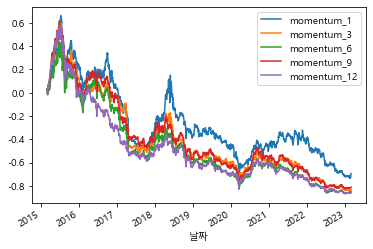

In [18]:
plt.figure(figsize=(10,10))
cumulative_return.plot()
plt.show()

## 전략 수정

5일 모멘텀과 10일모멘텀을 사용하기로 함.  
시장은 코스피만을 대상으로 하고, 리밸런싱 주기는 5일로 설정.  
다른 모든 방식은 동일    

In [19]:
# 1개월을 기준으로 rebalancing을 실시
start_date, end_date = "2015-01-10", "2023-03-01"
rebalance_dates = stock.get_market_ohlcv(start_date, end_date, "005930").index[::5]
rebalance_dates

DatetimeIndex(['2015-01-12', '2015-01-19', '2015-01-26', '2015-02-02',
               '2015-02-09', '2015-02-16', '2015-02-26', '2015-03-05',
               '2015-03-12', '2015-03-19',
               ...
               '2022-12-20', '2022-12-27', '2023-01-04', '2023-01-11',
               '2023-01-18', '2023-01-27', '2023-02-03', '2023-02-10',
               '2023-02-17', '2023-02-24'],
              dtype='datetime64[ns]', name='날짜', length=401, freq=None)

In [20]:
# 쓰이는 모든 티커들을 모음
all_tickers = []
for date in tqdm(rebalance_dates):
    kospi_tickers = stock.get_market_ticker_list(date, market='KOSPI')
    all_tickers += kospi_tickers
all_tickers = list(set(all_tickers))
print(f"해당 기간동안의 모든 ticker 개수는 {len(all_tickers)}")

100%|██████████| 401/401 [01:36<00:00,  4.16it/s]

해당 기간동안의 모든 ticker 개수는 1060


In [21]:
def return_price_df(tickers, start_date, end_date):
    df = pd.DataFrame()
    for ticker in tqdm(tickers):
        price_df = stock.get_market_ohlcv(start_date, end_date, ticker)['종가'].to_frame(ticker)
        df = pd.concat([df, price_df], axis=1)
    return df

price_df = return_price_df(all_tickers, start_date, end_date)
price_df.to_csv('momentum_price_df2.csv')

100%|██████████| 1060/1060 [01:34<00:00, 11.18it/s]


In [22]:
price_df = pd.read_csv('momentum_price_df2.csv', index_col=0)
price_df = price_df.fillna(0)
price_df.index = pd.to_datetime(price_df.index, format='%Y-%m-%d')
price_df.head()

,036570,010620,072130,004840,086280,077970,011200,002150,298040,000240,...,055490,083380,005870,002240,000970,015540,009155,011790,432320,027390
날짜,,,,,,,,,,,,,,,,,,,,,
2015-01-12,196500,35194,4565,11526,300000,12200,62977,4335,0.0,23900,...,0.0,4740.0,4765,29389,5230,33489,28850,27500,0.0,70800.0
2015-01-13,193500,34141,4955,11164,255000,12200,63285,4330,0.0,24550,...,0.0,4650.0,4820,29317,5140,33011,28950,27100,0.0,67700.0
2015-01-14,191500,33840,4700,11254,231500,12200,62670,4210,0.0,24500,...,0.0,4650.0,5150,29136,5080,32426,29900,27350,0.0,67900.0
2015-01-15,192000,34041,4600,11572,237500,12200,62670,4310,0.0,24750,...,0.0,4650.0,4970,28956,5100,32426,29600,27900,0.0,65100.0
2015-01-16,193000,32637,5290,11344,235000,12200,61441,4380,0.0,25200,...,0.0,4680.0,4970,28812,5210,30938,29200,27900,0.0,61300.0


In [23]:
momentum_5d = price_df.pct_change(5).replace(np.inf, 0).fillna(0).iloc[5:, :]
momentum_10d = price_df.pct_change(10).replace(np.inf, 0).fillna(0).iloc[10:, :]

def change_period(df):
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    df = df[df.index >= "2015-02-01"]
    return df
momentum_5d = change_period(momentum_5d)
momentum_10d = change_period(momentum_10d)
momentum_5d.head()

,036570,010620,072130,004840,086280,077970,011200,002150,298040,000240,...,055490,083380,005870,002240,000970,015540,009155,011790,432320,027390
날짜,,,,,,,,,,,,,,,,,,,,,
2015-02-02,0.058047,0.134966,-0.128440,0.064436,0.037363,0.0,0.033594,-0.013100,0.0,-0.025896,...,0.0,0.000000,0.052326,-0.003675,-0.023508,-0.028743,0.003300,0.036585,0.0,0.050473
2015-02-03,0.137566,0.091530,-0.061889,0.044340,-0.025157,0.0,0.041454,-0.026201,0.0,-0.049603,...,0.0,0.011591,0.009434,-0.006110,0.018622,-0.070332,0.001626,0.026490,0.0,0.064000
2015-02-04,0.006912,0.007900,-0.060359,0.074091,-0.026316,0.0,0.038896,-0.001092,0.0,-0.018109,...,0.0,0.008430,0.009346,-0.006050,0.153704,0.003366,0.043771,0.050420,0.0,0.048819
2015-02-05,0.026442,-0.027076,0.049069,0.061758,-0.022680,0.0,0.042794,0.001093,0.0,-0.013619,...,0.0,0.012645,-0.030909,0.065462,0.323475,0.012128,0.038526,0.054054,0.0,0.020218
2015-02-06,0.054455,-0.015554,0.028912,0.095859,0.026585,0.0,-0.041935,0.006623,0.0,-0.007937,...,0.0,0.015806,-0.003704,0.103319,0.364641,0.015503,0.003268,0.038017,0.0,-0.021053


In [24]:
def calculate_weights(momentum_df, long=50):
    long_signal = ((momentum_df
                  .where(momentum_df > 0)
                  .rank(axis=1, ascending=False) <= long)
                  .astype(int))
    def calculate_weights_from_signal(arr):
        signal = (arr == 1).astype(int)
        cnt = np.clip(np.sum(arr == 1), 0, long)
        if cnt > 0:
            signal = signal / cnt
        return signal
    long_signal = long_signal.apply(calculate_weights_from_signal, axis=1)
    return long_signal

In [25]:
momentum_5d_weights = calculate_weights(momentum_5d)
momentum_10d_weights = calculate_weights(momentum_10d)
momentum_5d_weights.head()

,036570,010620,072130,004840,086280,077970,011200,002150,298040,000240,...,055490,083380,005870,002240,000970,015540,009155,011790,432320,027390
날짜,,,,,,,,,,,,,,,,,,,,,
2015-02-02,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2015-02-03,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2015-02-04,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0
2015-02-05,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0
2015-02-06,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [26]:
# rebalance를 반영해서 weight를 수정
for date in momentum_5d_weights.index:
    if date not in rebalance_dates:
        momentum_5d_weights.loc[date, :] = np.nan
        momentum_10d_weights.loc[date, :] = np.nan
momentum_5d_weights = momentum_5d_weights.fillna(method='ffill')
momentum_5d_weights.index = pd.to_datetime(momentum_5d_weights.index, format='%Y-%m-%d')
momentum_10d_weights = momentum_10d_weights.fillna(method='ffill')
momentum_10d_weights.index = pd.to_datetime(momentum_10d_weights.index, format='%Y-%m-%d')

In [27]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.head()

,036570,010620,072130,004840,086280,077970,011200,002150,298040,000240,...,055490,083380,005870,002240,000970,015540,009155,011790,432320,027390
날짜,,,,,,,,,,,,,,,,,,,,,
2015-01-12,-0.015267,-0.029920,0.085433,-0.031407,-0.150000,0.0,0.004891,-0.001153,0.0,0.027197,...,0.0,-0.018987,0.011542,-0.002450,-0.017208,-0.014273,0.003466,-0.014545,0.0,-0.043785
2015-01-13,-0.010336,-0.008816,-0.051463,0.008062,-0.092157,0.0,-0.009718,-0.027714,0.0,-0.002037,...,0.0,0.000000,0.068465,-0.006174,-0.011673,-0.017721,0.032815,0.009225,0.0,0.002954
2015-01-14,0.002611,0.005940,-0.021277,0.028257,0.025918,0.0,0.000000,0.023753,0.0,0.010204,...,0.0,0.000000,-0.034951,-0.006178,0.003937,0.000000,-0.010033,0.020110,0.0,-0.041237
2015-01-15,0.005208,-0.041244,0.150000,-0.019703,-0.010526,0.0,-0.019611,0.016241,0.0,0.018182,...,0.0,0.006452,0.000000,-0.004973,0.021569,-0.045889,-0.013514,0.000000,0.0,-0.058372
2015-01-16,-0.020725,0.112143,0.043478,-0.007934,-0.004255,0.0,0.010010,0.059361,0.0,0.013889,...,0.0,0.002137,0.016097,-0.003748,0.015355,0.000000,0.000000,0.008961,0.0,0.014682


In [28]:
fwd_return = fwd_return[fwd_return.index >= "2015-03-01"]
momentum_5d_weights = momentum_5d_weights[momentum_5d_weights.index >= "2015-03-01"]
momentum_10d_weights = momentum_10d_weights[momentum_10d_weights.index >= "2015-03-01"]

In [29]:
# 일별 수익률 계산
daily_return = pd.DataFrame()
daily_return['momentum_5d'] = momentum_5d_weights.mul(fwd_return).sum(axis=1)
daily_return['momentum_10d'] = momentum_10d_weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2015-03-01") & (daily_return.index < "2023-02-28")]
daily_return.head()

,momentum_5d,momentum_10d
날짜,,
2015-03-02,0.009083,0.005574
2015-03-03,-0.006521,0.006392
2015-03-04,0.005194,0.017455
2015-03-05,-0.005348,-0.003355
2015-03-06,0.004559,0.002329


In [30]:
cumulative_return = daily_return.copy()
for col in cumulative_return.columns:
    cumulative_return[col] = np.exp(np.log(daily_return[col]+1).cumsum())-1
cumulative_return

,momentum_5d,momentum_10d
날짜,,
2015-03-02,0.009083,0.005574
2015-03-03,0.002503,0.012002
2015-03-04,0.007710,0.029667
2015-03-05,0.002321,0.026212
2015-03-06,0.006890,0.028602
...,...,...
2023-02-21,-0.682461,-0.609510
2023-02-22,-0.685316,-0.610748
2023-02-23,-0.688220,-0.613192


<Figure size 720x720 with 0 Axes>

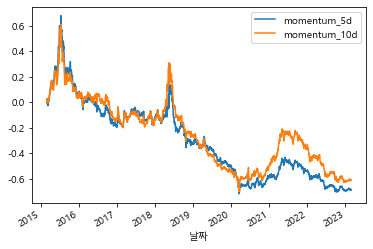

In [31]:
plt.figure(figsize=(10,10))
cumulative_return.plot()
plt.show()